## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_okjjfud because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Import data

### from Minres probe selection script

In [15]:
c = np.load("/beegfs/home/pmatyskova/project/ishfstep_c_hm185cor_coefvar_filled0.npy")
e = np.load("/beegfs/home/pmatyskova/project/ishfstep_e_hm185cor_coefvar_filled0.npy")
gene_annot = np.load("/beegfs/home/pmatyskova/project/ishfstep_geneset_hm185cor_coefvar_filled0.npy",allow_pickle=True)

In [16]:
c.shape

(3585, 185)

## Define and Calculate Residuals

In [17]:
def Resid(c_m, e_m):
    error_tot = np.full(len(c_m), np.inf)
    for i in range(len(c_m)):
        c_without_genei = np.delete(c_m, i, 0)
        e_without_genei = np.delete(e_m, i, 0)
        d_without_genei = np.matmul(np.linalg.pinv(c_without_genei), e_without_genei)
        error1 = sum((e_m[i,:] - np.matmul(c_m[i,:],d_without_genei))**2)
        error2 = sum((np.matmul(c_m[i,:], np.linalg.pinv(c_without_genei)))**2)*np.dot(e_m[i,:], e_m[i,:])
        error_tot[i] = error1 + error2
    return error_tot

In [18]:
gene_res = Resid(c, e)

## Filter high error genes

In [19]:
c_filt = c[0,:]
gene_annotations_filt = []
e_filt = e[0,:]

for i in range(len(c)):
    if gene_res[i] < np.percentile(gene_res, 95):
        c_filt = np.vstack([c_filt, c[i,:]])
        gene_annotations_filt.append(gene_annot[i]) 
        e_filt = np.vstack([e_filt, e[i,:]])
        
c_filt = np.delete(c_filt, 0, 0)
e_filt = np.delete(e_filt, 0, 0)

In [20]:
np.save(file = "/beegfs/home/pmatyskova/project/mrx3step_e_miss_hm185cor_coefvar_mrx395_filled0", arr = e_filt)
np.save(file = "/beegfs/home/pmatyskova/project/mrx3step_c_miss_hm185cor_coefvar_mrx395_filled0", arr = c_filt)
np.save(file = "/beegfs/home/pmatyskova/project/mrx3step_geneset_miss_hm185cor_coefvar_mrx395_filled0", arr = gene_annotations_filt)

## Residual analysis

to pick the 95th percentile

In [44]:
c_matrix = pd.read_csv("/beegfs/home/pmatyskova/project/c_matrix_ncfull_annot.csv")
gene_annotations = c_matrix['Unnamed: 0']

gene_res_ncannot = np.load("/beegfs/home/pmatyskova/project/gene_res_ncfull.npy")
gene_res_ncannot = pd.DataFrame(gene_res_ncannot)
gene_res_ncannot.index = gene_annotations
gene_res_ncannot.columns = ['resid']

gene_res_nc = np.load("/beegfs/home/pmatyskova/project/gene_res_ncfull.npy")

In [68]:
gene_res_ncannot_td = gene_res_ncannot.sort_values(by = 'resid', ascending=False)
bot3 = gene_res_ncannot_td.iloc[0:3,:]
gene_res_ncannot_du = gene_res_ncannot.sort_values(by = 'resid')
top3 = gene_res_ncannot_du.iloc[0:3,:]

In [69]:
all_bot = gene_res_ncannot.loc[gene_res_ncannot['resid'] > prec95]
nums = random.sample(range(0, all_bot.shape[0]), 3)
rand3_bad = all_bot.iloc[nums,:]

In [71]:
top3

,resid
Unnamed: 0,
Cdh3,3.794180
Sstr4,4.770167
Mas1,17.499791


In [72]:
bot3

,resid
Unnamed: 0,
Heatr5b,1.903910e+06
Flcn,1.761794e+06
Acsl5,1.687998e+06


In [73]:
rand3_bad

,resid
Unnamed: 0,
Cd81,257147.690016
Cdca7,574545.128675
Syn1,334826.445394


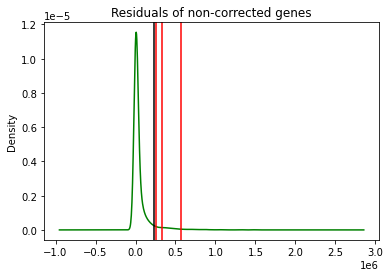

In [76]:
prec95 = np.percentile(gene_res_nc, 95)

gene_res_ncannot.resid.plot.density(color='green')
plt.axvline(prec95, color='black')
plt.axvline(rand3_bad.iloc[0,0], color='red')
plt.axvline(rand3_bad.iloc[1,0], color='red')
plt.axvline(rand3_bad.iloc[2,0], color='red')
plt.title('Residuals of non-corrected genes')
plt.show()